# Generalized Extreme Value Distribution

:::{post} Oct 19, 2021 
:tags: extreme, inference, prediction, pymc.Deterministic, pymc.GenExtreme, pymc.HalfNormal, pymc.Model, pymc.Normal, pymc.TruncatedNormal, pymc3.Deterministic, pymc3.HalfNormal, pymc3.Model, pymc3.Normal, pymc3.TruncatedNormal
:category: beginner 
:author: Colin Caprani 
:::

## Introduction

The Generalized Extreme Value (GEV) distribution is a meta-distribution containing the Weibull, Gumbel, and Frechet families of extreme value distributions. It is used for modelling the distribution of extremes (maxima or minima) of stationary processes, such as the annual maximum wind speed, annual maximum truck weight on a bridge, and so on, without needing *a priori* decision on the tail behaviour.

Following the parametrization used in {cite:t}`coles2001gev`, the GEV distribution for maxima is given by:

$$G(x) = \exp \left\{ \left[ 1 - \xi \left( \frac{x - \mu}{\sigma} \right) \right]^{-\frac{1}{\xi}} \right\}$$

when:
- $\xi < 0$ we get the Weibull distribution with a bounded upper tail;
- $\xi = 0$, in the limit, we get the Gumbel distribution, unbonded in both tails;
- $\xi > 0$, we get the Frechet distribution which is bounded in the lower tail.

Note that this parametrization of the shape parameter $\xi$ is opposite in sign to that used in SciPy (where it is denoted `c`). Further, the distribution for minima is readily examined by studying the distribution of maxima of the negative of the data.

We will use the example of the Port Pirie annual maximum sea-level data used in {cite:t}`coles2001gev`, and compare with the frequentist results presented there.

In [1]:
import aesara.tensor as at
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import pymc_experimental.distributions as pmx

from arviz.plots import plot_utils as azpu

## Data
The Port Pirie data is provided by {cite:t}`coles2001gev`, and repeated here:

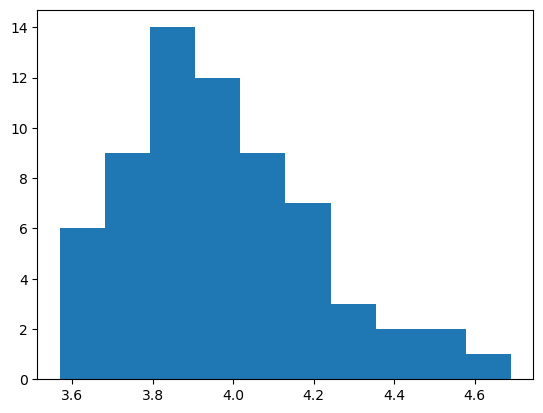

In [2]:
# fmt: off
data = np.array([4.03, 3.83, 3.65, 3.88, 4.01, 4.08, 4.18, 3.80, 
                 4.36, 3.96, 3.98, 4.69, 3.85, 3.96, 3.85, 3.93, 
                 3.75, 3.63, 3.57, 4.25, 3.97, 4.05, 4.24, 4.22, 
                 3.73, 4.37, 4.06, 3.71, 3.96, 4.06, 4.55, 3.79, 
                 3.89, 4.11, 3.85, 3.86, 3.86, 4.21, 4.01, 4.11, 
                 4.24, 3.96, 4.21, 3.74, 3.85, 3.88, 3.66, 4.11, 
                 3.71, 4.18, 3.90, 3.78, 3.91, 3.72, 4.00, 3.66, 
                 3.62, 4.33, 4.55, 3.75, 4.08, 3.90, 3.88, 3.94, 
                 4.33])
# fmt: on
plt.hist(data)
plt.show()

## Modelling & Prediction
In the modelling we wish to do two thing:

- parameter inference on the GEV parameters, based on some fairly non-informative priors, and;
- prediction of the 10-year return level.

Predictions of extreme values considering parameter uncertainty are easily accomplished in the Bayesian setting. It is interesting to compare this ease to the difficulties encountered by {cite:t}`caprani2010gev` in doing this in a frequentist setting. In any case, the predicted value at a probability of exceedance $p$ is given by:

$$ x_p = \mu - \frac{\sigma}{\xi} \left\{1 - \left[-\log\left(1-p\right)\right] \right\} $$

This is a deterministic function of the parameter values, and so is accomplished using `pm.Deterministic` within the model context.

Consider then, the 10-year return period, for which $p = 1/10$:

In [3]:
p = 1 / 10

And now set up the model using priors estimated from a quick review of the historgram above:

- $\mu$: there is no real basis for considering anything other than a `Normal` distribution with a standard deviation limiting negative outcomes;
- $\sigma$: this must be positive, and has a small value, so use `HalfNormal` with a unit standard deviation;
- $\xi$: we are agnostic to the tail behaviour so centre this at zero, but limit to physically reasonable bounds of $\pm 0.6$, and keep it somewhat tight near zero.

In [4]:
# Optionally centre the data, depending on fitting and divergences
# cdata = (data - data.mean())/data.std()

with pm.Model() as model:
    # Priors
    μ = pm.Normal("μ", mu=3.8, sigma=0.2)
    σ = pm.HalfNormal("σ", sigma=0.3)
    ξ = pm.TruncatedNormal("ξ", mu=0, sigma=0.2, lower=-0.6, upper=0.6)

    # Estimation
    gev = pmx.GenExtreme("gev", mu=μ, sigma=σ, xi=ξ, observed=data)
    # Return level
    z_p = pm.Deterministic("z_p", μ - σ / ξ * (1 - (-np.log(1 - p)) ** (-ξ)))

## Prior Predictive Checks
Let's get a feel for how well our selected priors cover the range of the data:

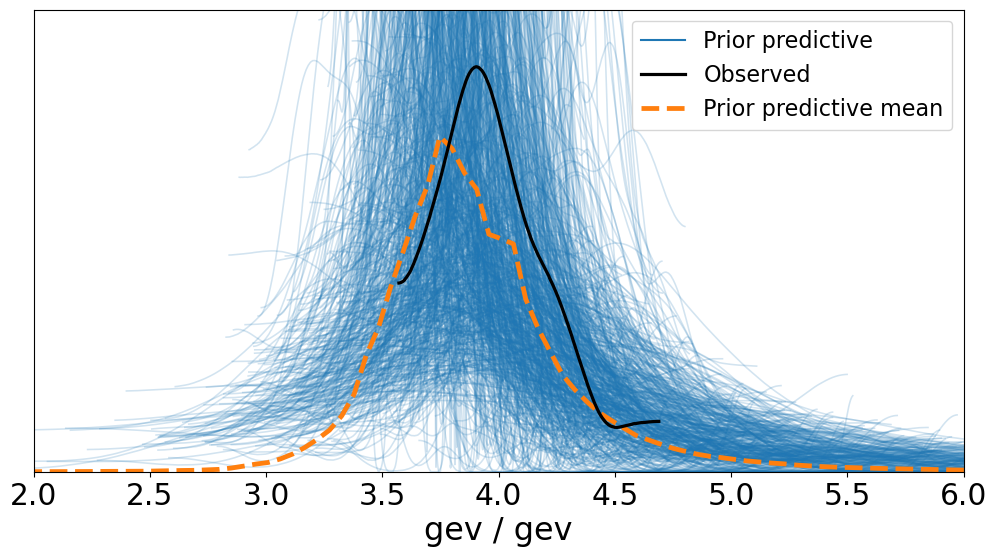

In [5]:
idata = pm.sample_prior_predictive(samples=1000, model=model)
az.plot_ppc(idata, group="prior", figsize=(12, 6))
ax = plt.gca()
ax.set_xlim([2, 6])
ax.set_ylim([0, 2]);

And we can look at the sampled values of the parameters, using the `plot_posterior` function, but passing in the `idata` object and specifying the `group` to be `"prior"`:

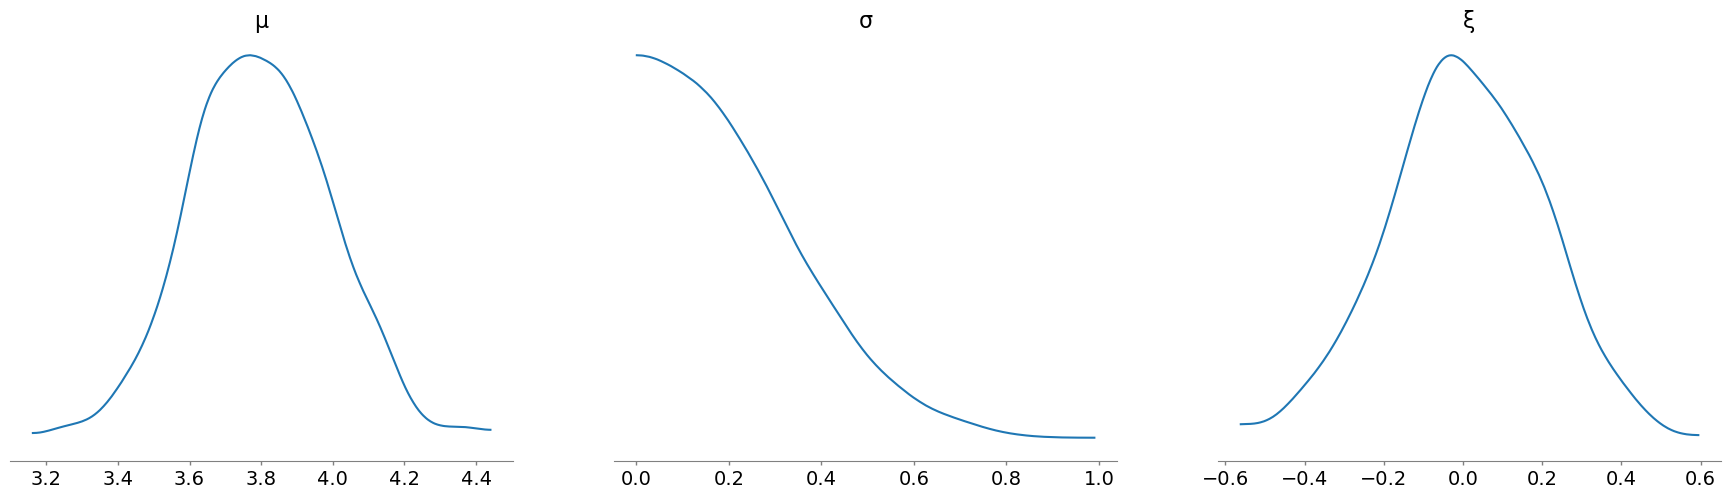

In [6]:
az.plot_posterior(
    idata, group="prior", var_names=["μ", "σ", "ξ"], hdi_prob="hide", point_estimate=None
);

## Inference
Press the magic Inference Button$^{\mathrm{TM}}$:

In [7]:
with model:
    trace = pm.sample(
        5000,
        cores=4,
        chains=4,
        tune=2000,
        initvals={"μ": -0.5, "σ": 1.0, "ξ": -0.1},
        target_accept=0.95,
    )
# add trace to existing idata object
idata.extend(trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ, σ, ξ]


Sampling 4 chains for 2_000 tune and 5_000 draw iterations (8_000 + 20_000 draws total) took 12 seconds.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.


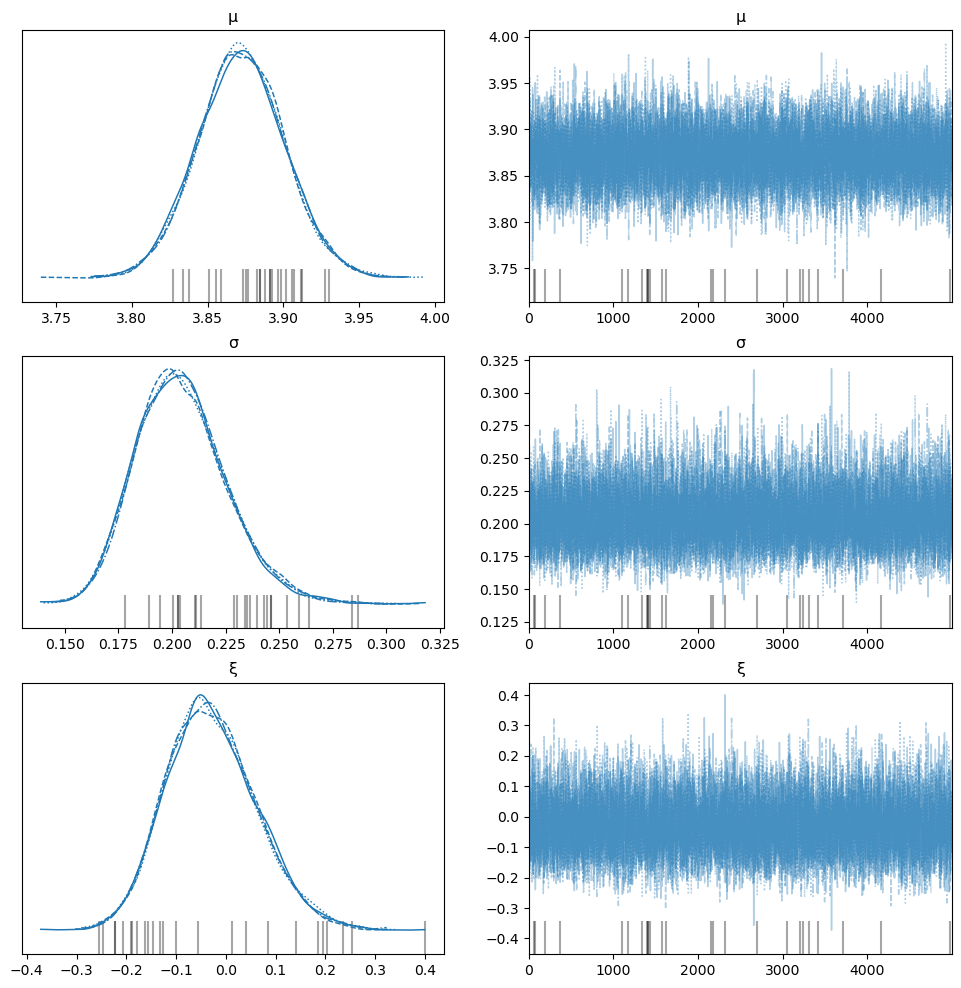

In [8]:
az.plot_trace(idata, var_names=["μ", "σ", "ξ"], figsize=(12, 12));

### Divergences
The trace exhibits divergences (usually). The HMC/NUTS sampler can have problems when the bounds of support for parameters are approached. And since the bounds of the GEV change with the sign of $\xi$, it is difficult to offer a transformation that resolves this problem. One possible transformation - the Box-Cox - has been proposed by {cite:t}`bali2003gev`, but {cite:t}`caprani2009gev` find it numerically unstable, even for just maximum likelihood estimation. In any case, recommendations to alleviate divergence problems are:

- Increase the target acceptance ratio;
- Use more informative priors, especially limit the shape parameter to physically reasonable values, typically $\xi \in [-0.5,0.5]$;
- Decide upon the domain of attraction of the tail (i.e. Weibull, Gumbel, or Frechet), and use that distribution directly.


### Inferences
The 95% credible interval range of the parameter estimates is:

In [9]:
az.hdi(idata, hdi_prob=0.95)

<xarray.Dataset>
Dimensions:  (hdi: 2)
Coordinates:
  * hdi      (hdi) <U6 'lower' 'higher'
Data variables:
    μ        (hdi) float64 3.814 3.927
    σ        (hdi) float64 0.1653 0.2472
    ξ        (hdi) float64 -0.1965 0.1545
    z_p      (hdi) float64 4.206 4.442

And examine the prediction distribution, considering parameter variability (and without needing to assume normality):

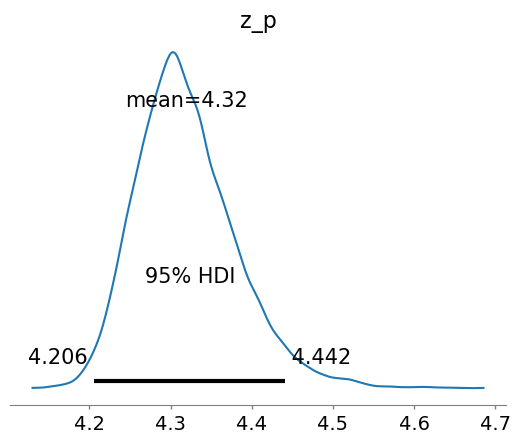

In [10]:
az.plot_posterior(idata, hdi_prob=0.95, var_names=["z_p"], round_to=4);

And let's compare the prior and posterior predictions of $z_p$ to see how the data has influenced things:

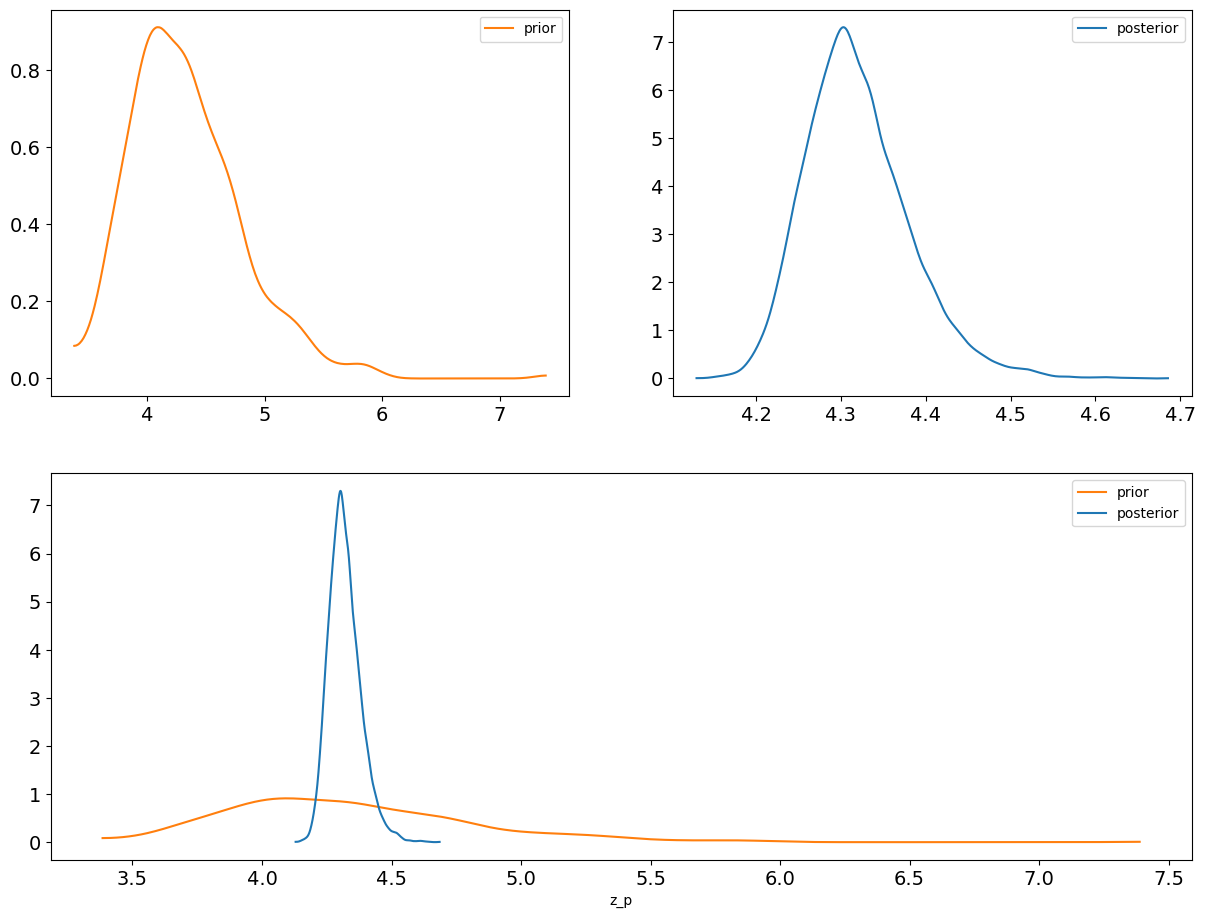

In [11]:
az.plot_dist_comparison(idata, var_names=["z_p"]);

## Comparison
To compare with the results given in {cite:t}`coles2001gev`, we approximate the maximum likelihood estimates (MLE) using the mode of the posterior distributions (the *maximum a posteriori* or MAP estimate). These are close when the prior is reasonably flat around the posterior estimate.

The MLE results given in {cite:t}`coles2001gev` are:

$$\left(\hat{\mu}, \hat{\sigma}, \hat{\xi} \right) = \left( 3.87, 0.198, -0.050 \right) $$


And the variance-covariance matrix of the estimates is:

$$ V = \left[ \begin{array} 0.000780 & 0.000197 & -0.00107 \\
                            0.000197 & 0.000410 &  -0.000778 \\
                            -0.00107 & -0.000778 & 0.00965 
              \end{array} \right] $$


Note that extracting the MLE estimates from our inference involves accessing some of the Arviz back end functions to bash the xarray into something examinable:

In [12]:
_, vals = az.sel_utils.xarray_to_ndarray(idata["posterior"], var_names=["μ", "σ", "ξ"])
mle = [azpu.calculate_point_estimate("mode", val) for val in vals]
mle

[3.8674873102944307, 0.20053157835050156, -0.053378140537064855]

In [13]:
idata["posterior"].drop_vars("z_p").to_dataframe().cov().round(6)

,μ,σ,ξ
μ,0.000814,0.000185,-0.000849
σ,0.000185,0.000450,-0.000617
ξ,-0.000849,-0.000617,0.008157


The results are a good match, but the benefit of doing this in a Bayesian setting is we get the full posterior joint distribution of the parameters and the return level, essentially for free. Compare this to the loose normality assumption and computational effort to get even the variance-covarince matrix, as done in {cite:t}`coles2001gev`.

Finally, we examine the pairs plots and see where any difficulties in inference lie using the divergences

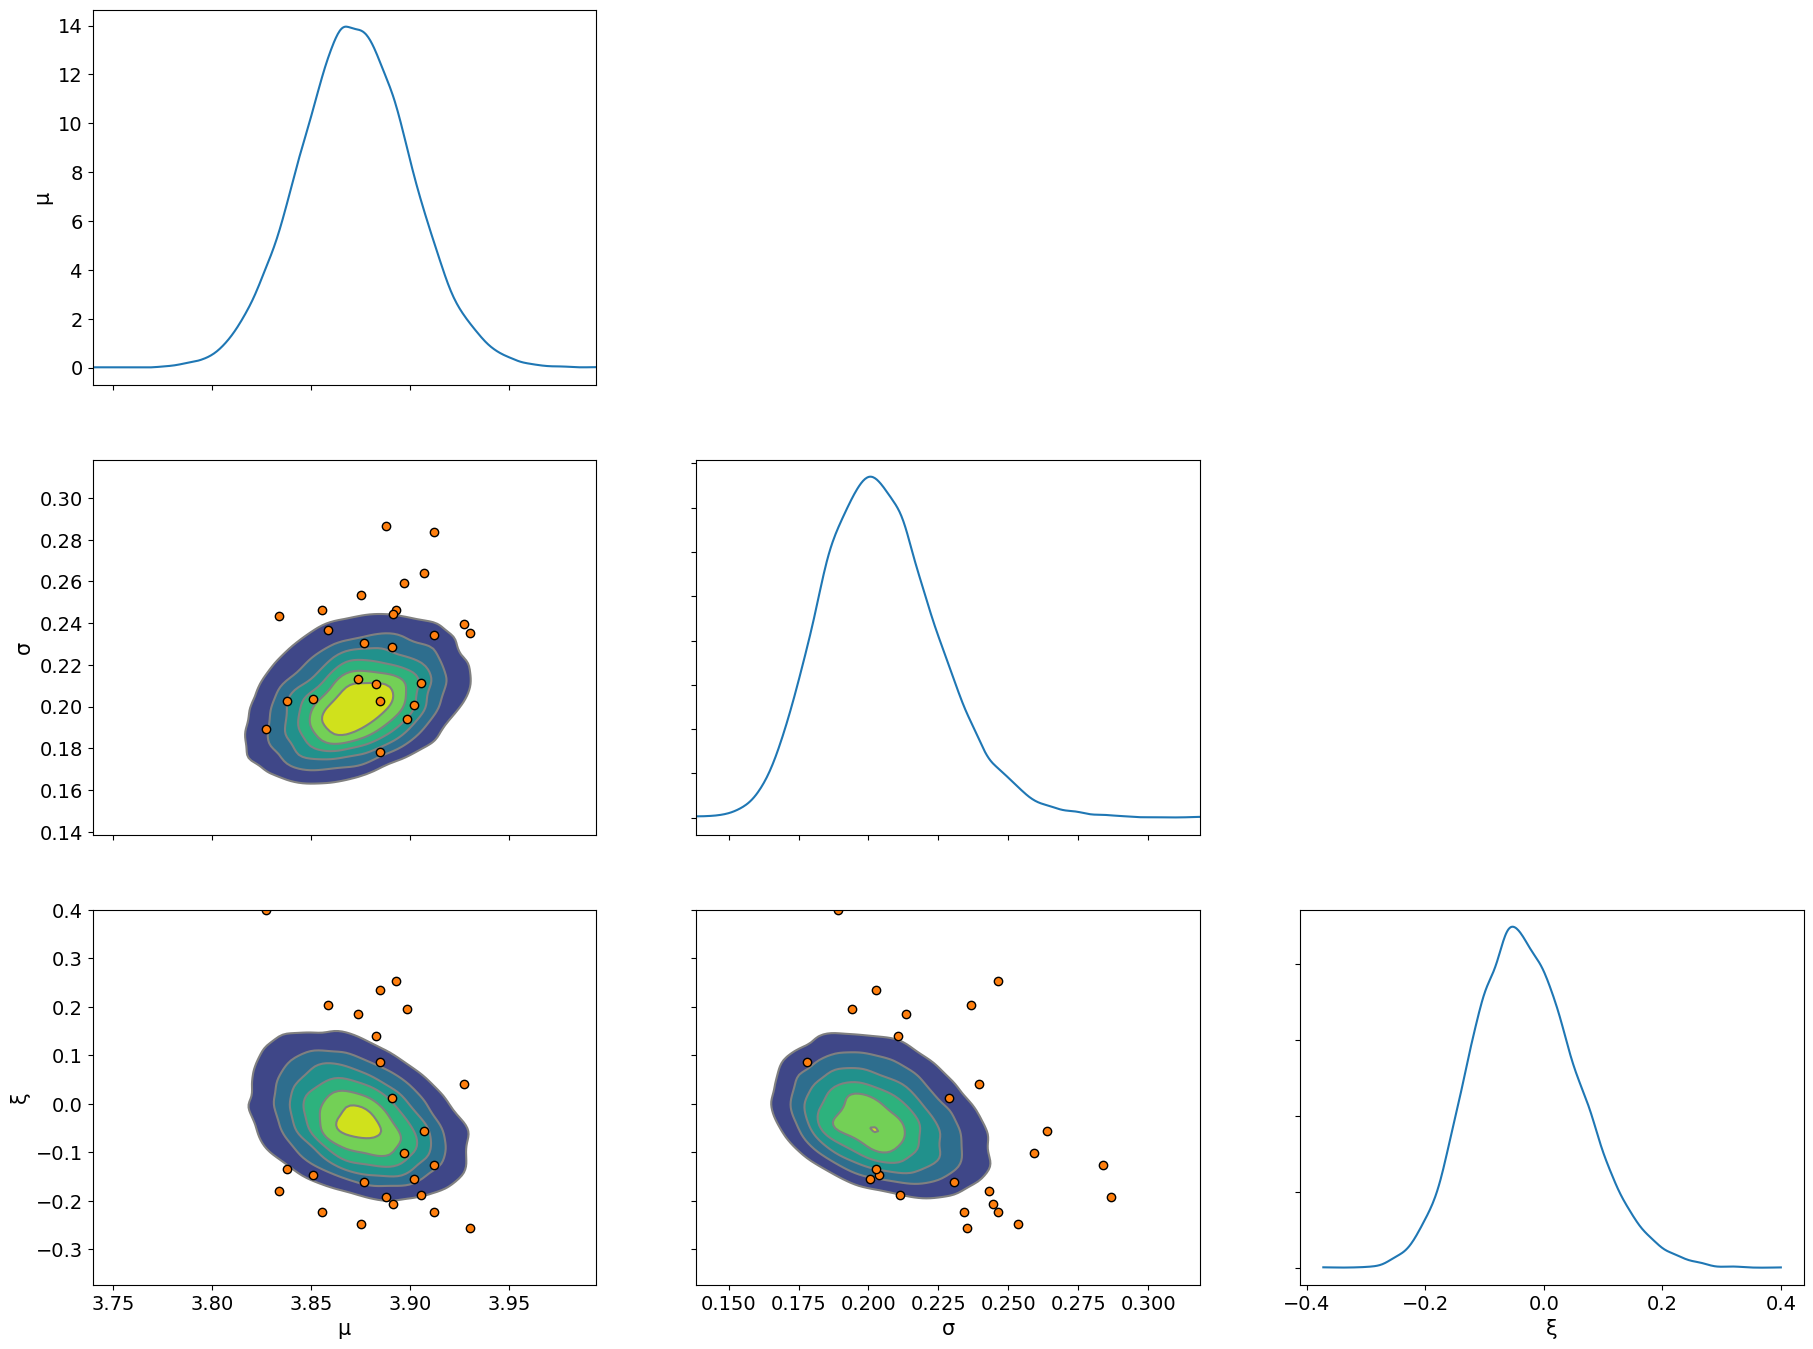

In [14]:
az.plot_pair(idata, var_names=["μ", "σ", "ξ"], kind="kde", marginals=True, divergences=True);

## Authors

* Authored by [Colin Caprani](https://github.com/ccaprani), October 2021

## References

:::{bibliography}
:filter: docname in docnames
:::

## Watermark

In [15]:
%load_ext watermark
%watermark -n -u -v -iv -w -p aesara,arviz

Last updated: Mon Sep 26 2022

Python implementation: CPython
Python version       : 3.10.6
IPython version      : 8.5.0

aesara: 2.7.4
arviz : 0.12.1

numpy            : 1.23.3
aesara           : 2.7.4
pymc             : 4.1.1
json             : 2.0.9
sys              : 3.10.6 | packaged by conda-forge | (main, Aug 22 2022, 20:36:39) [GCC 10.4.0]
arviz            : 0.12.1
matplotlib       : 3.6.0
pymc_experimental: 0.0.1

Watermark: 2.3.1

